In [17]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.functions import density_contour

def bin_data(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr

Text(0, 0.5, 'Logdist derived with AB magnitude')

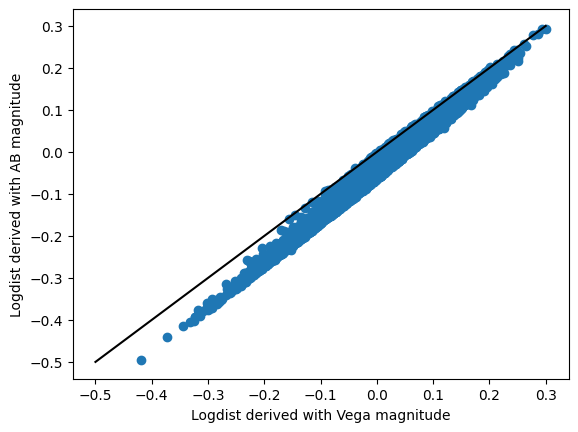

In [18]:
# Load data
req_cols = ["tmass", "z_dist_est", "logdist_all_combined"]
df_vega = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")[req_cols]
df_ab = pd.read_csv("./sdss.csv")[req_cols]

df = df_vega.merge(df_ab, on="tmass", suffixes=("_vega", "_ab"))

plt.scatter(df["logdist_all_combined_vega"], df["logdist_all_combined_ab"])
plt.plot([-0.5, 0.3], [-0.5, 0.3], c='k')
plt.xlabel("Logdist derived with Vega magnitude")
plt.ylabel("Logdist derived with AB magnitude")

Text(0, 0.5, 'logdist_vega $-$ logdist_ab')

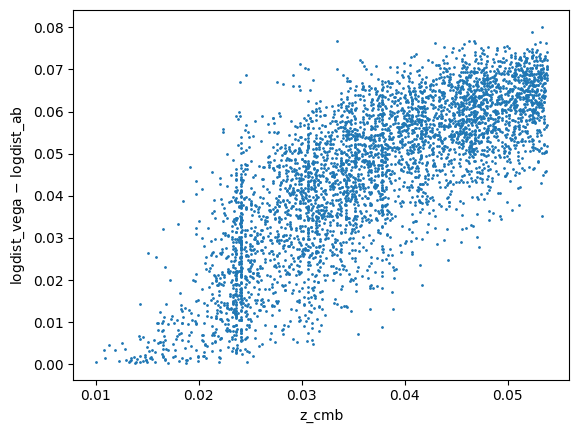

In [16]:
df["delta_logdist"] = df["logdist_all_combined_vega"] - df["logdist_all_combined_ab"]
plt.scatter(df["z_dist_est_ab"], df["delta_logdist"], s=1)
plt.xlabel("z_cmb")
plt.ylabel(r"logdist_vega $-$ logdist_ab")

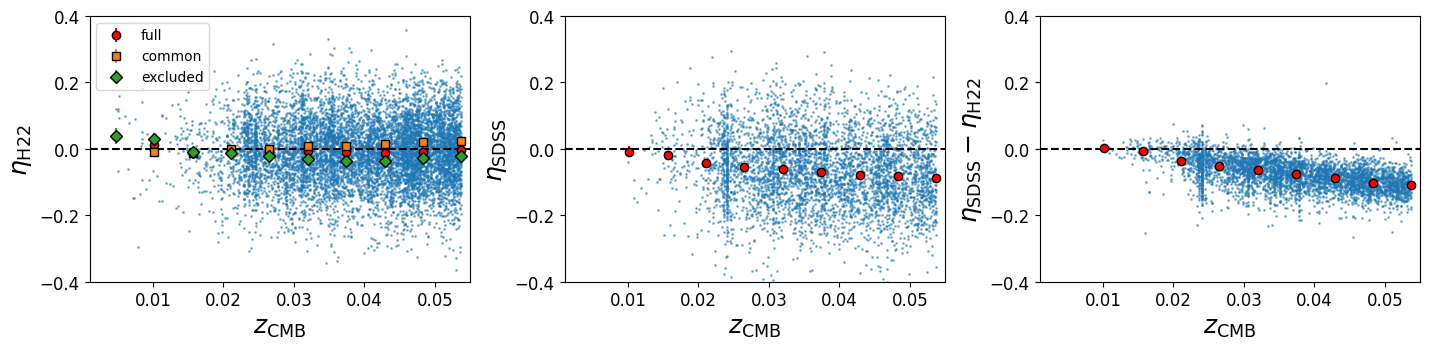

In [20]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("./sdss.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_cullan['objid'] = df_cullan['objid'].apply(lambda x: "SDSS" + str(x))
df_cullan = df_cullan[df_cullan['zcmb_group'] <= ZMAX]

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_corr', 'logdist_corr_err']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()
# fig.savefig('./sdss_comparison.pdf', bbox_inches='tight', dpi=300)

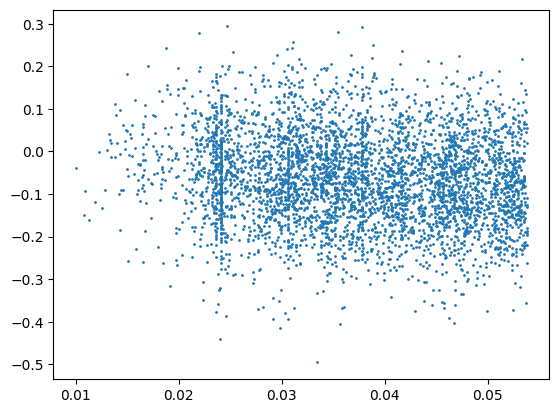

In [23]:
plt.scatter(df_ab["z_dist_est"], df_ab["logdist_all_combined"], s=1)